# Udacity Deep Reinforcement Learning Nanodegree

## Project 3 (Collaboration and Competition)

---

### 1. Environment setup

Run this notebook on root directory, following the instructions provided on README.md file.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `env_filename` variable to point to the location of the Unity environment file.

In [2]:
env_filename = './Tennis_Linux_NoVis/Tennis.x86_64'

In [3]:
env = UnityEnvironment(file_name=env_filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import random
import torch

from collections import deque
from ddpg_agent import Agent

In [8]:
# DDPG function

def ddpg(agent, n_episodes=2500, max_t=1000, print_every=1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    max_scores = []                               # list of max scores from each episode
    moving_avgs = []                              # list of moving averages
    best_score  = -np.inf
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()

        for t in range(max_t):
            actions = agent.act(states, add_noise=True)  # select an action

            env_info = env.step(actions)[brain_name]                    # send actions to environment
            next_states = env_info.vector_observations                  # get next state
            rewards = env_info.rewards                                  # get reward
            dones = env_info.local_done                                 # see if episode has finished

            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        max_scores.append(np.max(scores))           # save max score for the episode
        scores_window.append(max_scores[-1])        # save max score to window
        moving_avgs.append(np.mean(scores_window))  # save moving average

        if i_episode % print_every == 0:
            print('\rEpisode {} > Max: {:.1f} \t Moving Avg: {:.1f}'.format(str(i_episode).zfill(4),
                                                                            max_scores[-1], moving_avgs[-1]))

        if moving_avgs[-1] >= 0.5 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes! Average Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return max_scores, moving_avgs

In [9]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size)
scores, avgs = ddpg(agent, print_every=10)

Episode 0010 > Max: 0.0 	 Moving Avg: 0.0
Episode 0020 > Max: 0.0 	 Moving Avg: 0.0
Episode 0030 > Max: 0.0 	 Moving Avg: 0.0
Episode 0040 > Max: 0.0 	 Moving Avg: 0.0
Episode 0050 > Max: 0.0 	 Moving Avg: 0.0
Episode 0060 > Max: 0.0 	 Moving Avg: 0.0
Episode 0070 > Max: 0.0 	 Moving Avg: 0.0
Episode 0080 > Max: 0.0 	 Moving Avg: 0.0
Episode 0090 > Max: 0.0 	 Moving Avg: 0.0
Episode 0100 > Max: 0.0 	 Moving Avg: 0.0
Episode 0110 > Max: 0.0 	 Moving Avg: 0.0
Episode 0120 > Max: 0.0 	 Moving Avg: 0.0
Episode 0130 > Max: 0.0 	 Moving Avg: 0.0
Episode 0140 > Max: 0.0 	 Moving Avg: 0.0
Episode 0150 > Max: 0.1 	 Moving Avg: 0.0
Episode 0160 > Max: 0.0 	 Moving Avg: 0.0
Episode 0170 > Max: 0.0 	 Moving Avg: 0.0
Episode 0180 > Max: 0.0 	 Moving Avg: 0.0
Episode 0190 > Max: 0.0 	 Moving Avg: 0.0
Episode 0200 > Max: 0.0 	 Moving Avg: 0.0
Episode 0210 > Max: 0.0 	 Moving Avg: 0.0
Episode 0220 > Max: 0.0 	 Moving Avg: 0.0
Episode 0230 > Max: 0.0 	 Moving Avg: 0.0
Episode 0240 > Max: 0.0 	 Moving A

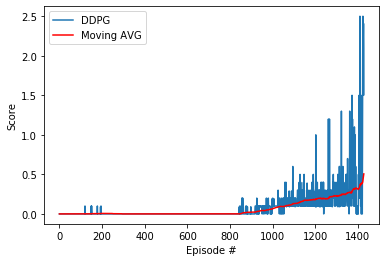

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [11]:
env.close()